# Module -> Cell Crop Preprocessing Module
April 9, 2025

In [37]:
# Image Preprocessing Script
# numpy, opencv-python, torch, torchvision, matplotlib, scikit-image
# 2025-04-08

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

directory = 'D:/jungha/2025 Spring/MEC510/term project/Processed_Data/03 Module Test/0_EL/NY_TC_0_#4.jpg'

# image name separated from directory, separate the .bmp extension
image_name = directory.split('/')[-1].split('.')[0]
print(image_name)

# image folder name separated from directory 
folder_name = directory.split('/')[-2]
print(folder_name)

if not os.path.exists(directory):
    print(f"Directory {directory} does not exist.")
    exit(1)

save_directory = 'D:/jungha/2025 Spring/MEC510/term project/Processed_Data/03 Module Test/'+ folder_name +'/' + image_name
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

NY_TC_0_#4
0_EL


### Normalization (Intensity)

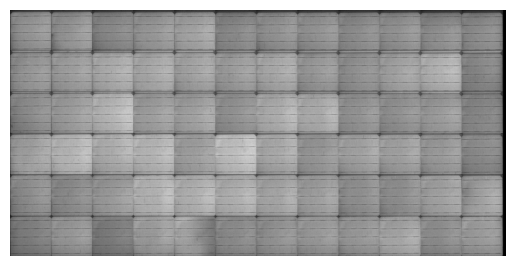

In [39]:
# normalize the image intensity because brightness is different

img = cv2.imread(directory, cv2.IMREAD_GRAYSCALE)

# min-max normalization
img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# histogram equalization
# img = cv2.equalizeHist(img)

# show normalized image
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()


## SOBEL HORIZONTAL DIRECTION!

Text(0.5, 1.0, 'Binary Sobel Image')

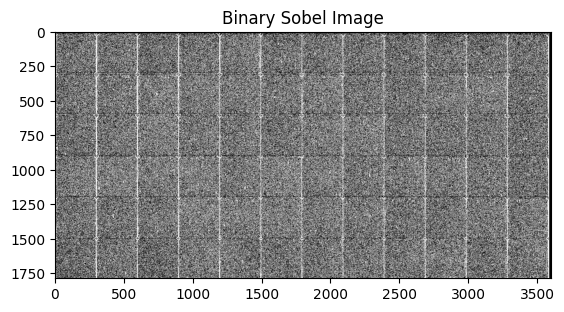

In [40]:

# sobel edge, dx =1, dy=0
sobel_edges = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
sobel_edges = cv2.convertScaleAbs(sobel_edges)

# fig, ax = plt.subplots(1, 2, figsize=(15, 10))

# ax[0].imshow(img, cmap='gray')
# ax[0].set_title('Original Grayscale Image')
# ax[0].axis('off')

# ax[1].imshow(sobel_edges, cmap='gray')
# ax[1].set_title('Sobel Detection')
# ax[1].axis('off')

# plt.show()

# show the edges image not using matplotlib
# figure = plt.figure(figsize=(15, 10))
# plt.imshow(sobel_edges, cmap='gray')

# save the edgses image
# cv2.imwrite('edges.png', sobel_edges)

_, binary_sobel = cv2.threshold(sobel_edges, 200, 255, cv2.THRESH_BINARY)

plt.imshow(binary_sobel, cmap='gray')
plt.title('Binary Sobel Image')

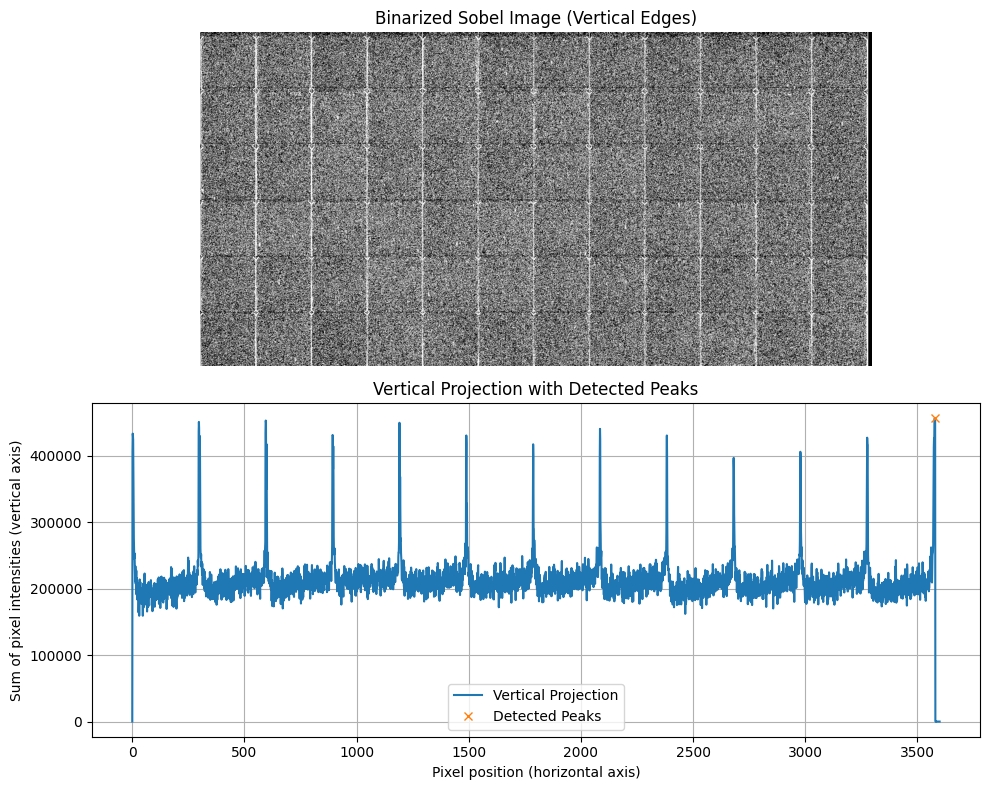

In [41]:
from scipy.signal import find_peaks

new_vertical_projection = np.sum(binary_sobel, axis=0)
# Step 3: Detect peaks in vertical projection
new_peaks, _ = find_peaks(new_vertical_projection, prominence=300000)
# Step 4: Visualize results
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Show binary Sobel image
ax[0].imshow(binary_sobel, cmap='gray')
ax[0].set_title('Binarized Sobel Image (Vertical Edges)')
ax[0].axis('off')

# Show vertical projection with detected peaks
ax[1].plot(new_vertical_projection, label='Vertical Projection')
ax[1].plot(new_peaks, new_vertical_projection[new_peaks], "x", label='Detected Peaks')
ax[1].set_title('Vertical Projection with Detected Peaks')
ax[1].set_xlabel('Pixel position (horizontal axis)')
ax[1].set_ylabel('Sum of pixel intensities (vertical axis)')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

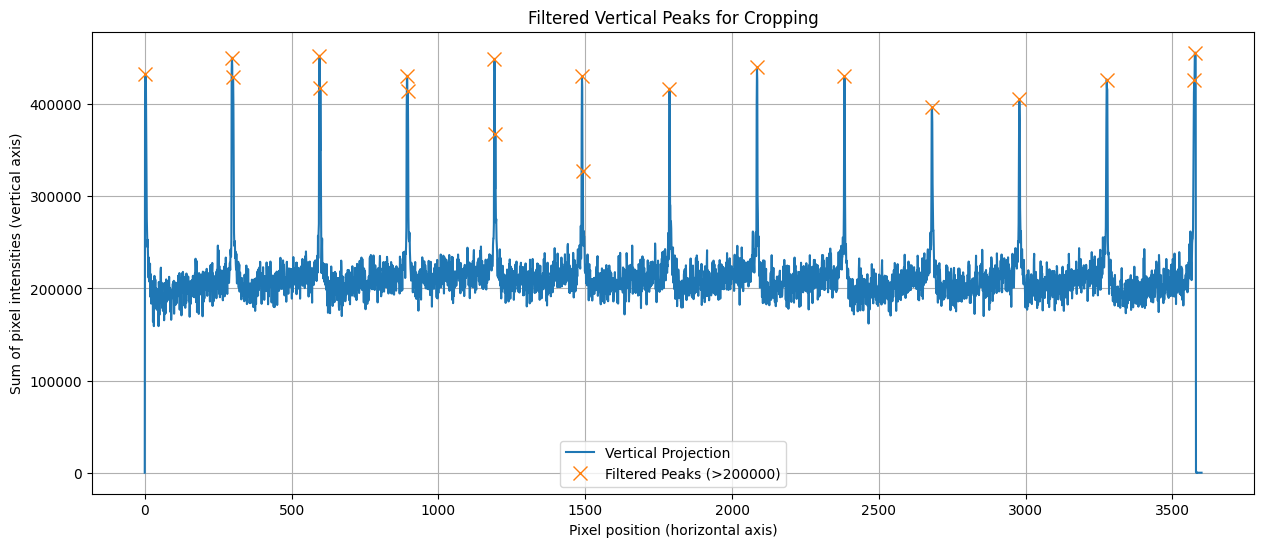

array([   2,  297,  301,  595,  598,  893,  896, 1191, 1194, 1489, 1492,
       1787, 2085, 2383, 2681, 2978, 3276, 3574, 3578])

In [42]:
# High-pass filter on peaks (threshold: 250000)
high_peaks, properties = find_peaks(new_vertical_projection, height=300000)

# Visualize the filtered peaks clearly
plt.figure(figsize=(15, 6))
plt.plot(new_vertical_projection, label='Vertical Projection')
plt.plot(high_peaks, new_vertical_projection[high_peaks], "x", markersize=10, label='Filtered Peaks (>200000)')
plt.title('Filtered Vertical Peaks for Cropping')
plt.xlabel('Pixel position (horizontal axis)')
plt.ylabel('Sum of pixel intensities (vertical axis)')
plt.legend()
plt.grid(True)
plt.show()

# Output detected high peaks positions clearly
high_peaks

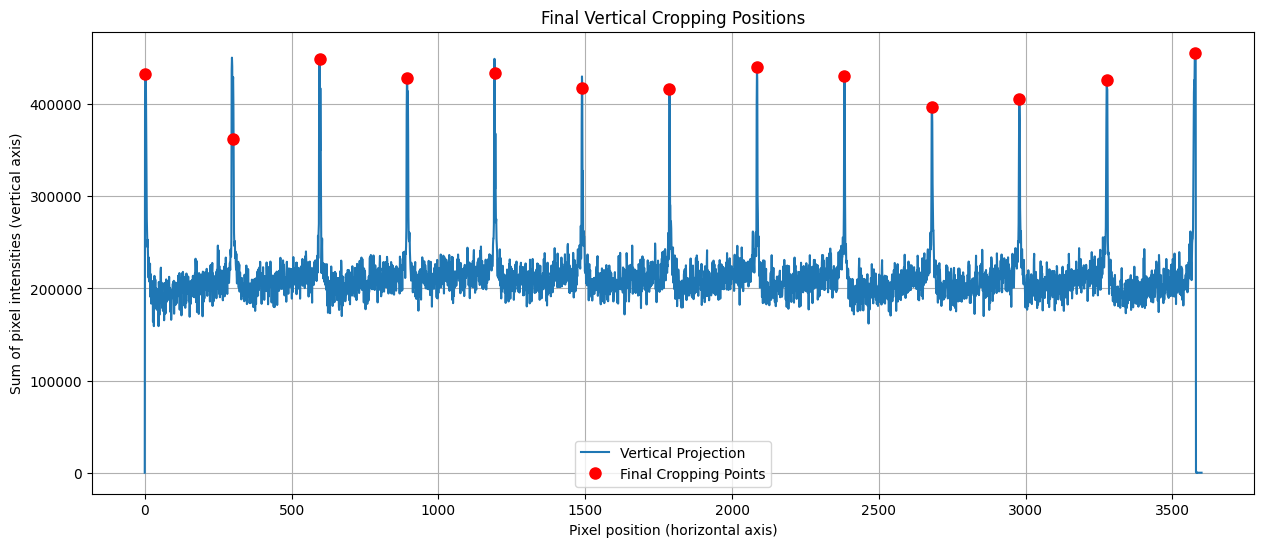

array([   2,  299,  596,  894, 1192, 1490, 1787, 2085, 2383, 2681, 2978,
       3276, 3576])

In [43]:
from sklearn.cluster import DBSCAN

# Convert peak positions into a format suitable for clustering (reshape into 2D array)
peak_positions = high_peaks.reshape(-1, 1)

# Apply DBSCAN clustering algorithm to group nearby peaks into single clusters
clustering = DBSCAN(eps=30, min_samples=1).fit(peak_positions)

# Get cluster labels
labels = clustering.labels_

# Calculate mean position for each cluster
horizontal_peaks = np.array([peak_positions[labels == i].mean() for i in np.unique(labels)]).astype(int)

# Sort the lines for clarity
horizontal_peaks.sort()

# Visualize clearly
plt.figure(figsize=(15, 6))
plt.plot(new_vertical_projection, label='Vertical Projection')
plt.plot(horizontal_peaks, new_vertical_projection[horizontal_peaks], "ro", markersize=8, label='Final Cropping Points')
plt.title('Final Vertical Cropping Positions')
plt.xlabel('Pixel position (horizontal axis)')
plt.ylabel('Sum of pixel intensities (vertical axis)')
plt.legend()
plt.grid(True)
plt.show()

# Output the final cropping positions
horizontal_peaks

In [44]:

def crop_columns(image_path, horizontal_lines, output_dir):
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    output_dir = output_dir + '/cropped_columns/'

    if image is None:
        print(f"❌ Error: Image not found at {image_path}")
        return

    height, width = image.shape
    horizontal_lines = sorted(set(horizontal_lines))

    os.makedirs(output_dir, exist_ok=True)

    # Crop columns using adjacent vertical lines
    for idx in range(len(horizontal_lines) - 1):
        x1 = horizontal_lines[idx]
        x2 = horizontal_lines[idx + 1]

        # Safety check
        if x2 > x1 and x2 <= width:
            column = image[:, x1:x2]
            save_path = os.path.join(output_dir, f"column_{idx+1}.png")
            cv2.imwrite(save_path, column)

    print(f"✅ {len(horizontal_lines) - 1} columns saved to '{output_dir}'.")
    
# Run the column cropping
crop_columns(directory, horizontal_peaks, save_directory)


✅ 12 columns saved to 'D:/jungha/2025 Spring/MEC510/term project/Processed_Data/03 Module Test/0_EL/NY_TC_0_#4/cropped_columns/'.


# VERTICAL SOBEL

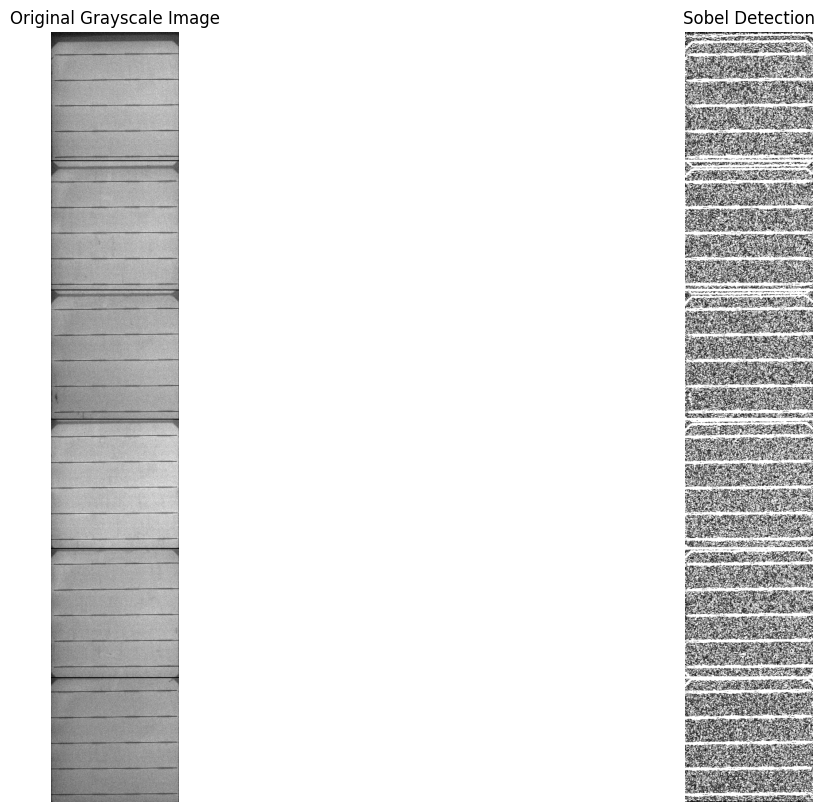

47
final vertical lines length: 38
[   7   23   51  111  169  229  294  314  346  405  466  524  583  605
  642  702  762  823  883  898  909  938  998 1059 1116 1175 1201 1235
 1293 1352 1413 1475 1498 1529 1590 1650 1708 1769]
these are the selected peaks: 
 [   7  300  594  888 1181 1475 1769]
✅ 6 rows saved from column_1.png
✅ 6 rows saved from column_10.png
✅ 6 rows saved from column_11.png
✅ 6 rows saved from column_12.png
✅ 6 rows saved from column_2.png
✅ 6 rows saved from column_3.png
✅ 6 rows saved from column_4.png
✅ 6 rows saved from column_5.png
✅ 6 rows saved from column_6.png
✅ 6 rows saved from column_7.png
✅ 6 rows saved from column_8.png
✅ 6 rows saved from column_9.png


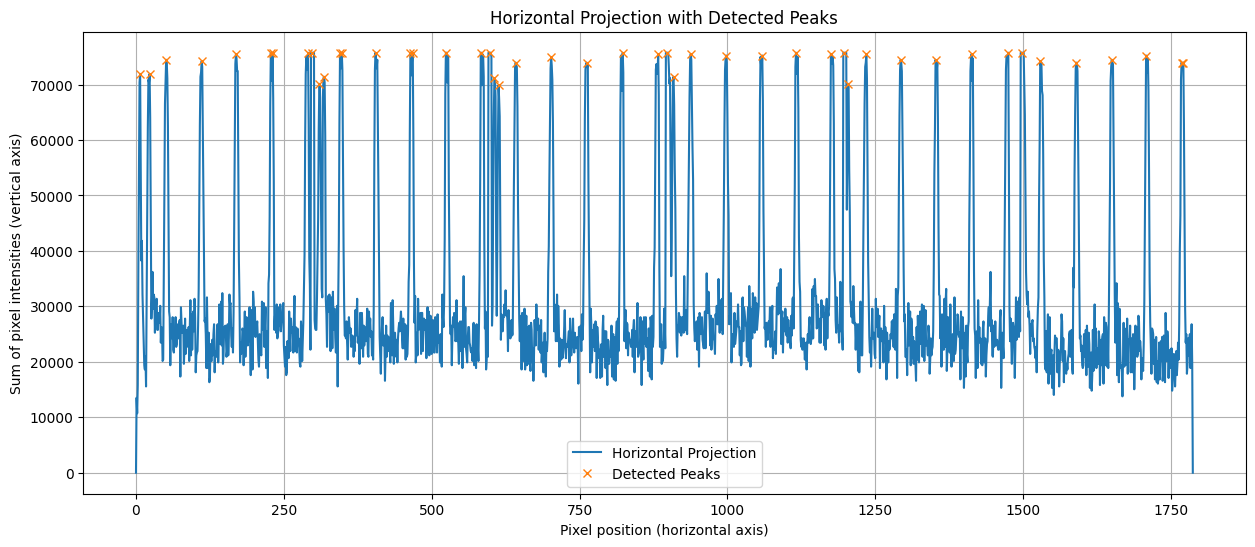

In [45]:
vertical_directory = save_directory + '/cropped_columns/'

for filename in os.listdir(vertical_directory):
    if filename.endswith('.png'):
        img = cv2.imread(os.path.join(vertical_directory, filename), cv2.IMREAD_GRAYSCALE)
        break

# sobel edge, dx =0, dy=1
sobel_edges_horizontal = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
sobel_edges_horizontal = cv2.convertScaleAbs(sobel_edges_horizontal)

fig, ax = plt.subplots(1, 2, figsize=(15, 10))

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Grayscale Image')
ax[0].axis('off')

ax[1].imshow(sobel_edges_horizontal, cmap='gray')
ax[1].set_title('Sobel Detection')
ax[1].axis('off')

plt.show()

# save the edgses image
cv2.imwrite('edges.png', sobel_edges_horizontal)

_, binary_sobel_hor = cv2.threshold(sobel_edges_horizontal, 200, 255, cv2.THRESH_BINARY)

new_horizontal_projection = np.sum(binary_sobel_hor, axis=1)
new_peaks, _ = find_peaks(new_horizontal_projection, prominence=20000)

print(len(new_peaks))

#figure.plt(new_vertical_projection, label='Vertical Projection')
#figure.plt(new_peaks, new_vertical_projection[new_peaks], "x", label='Detected Peaks')
# how do i make just the peaks figures
plt.figure(figsize=(15, 6))
plt.plot(new_horizontal_projection, label='Horizontal Projection')   
plt.plot(new_peaks, new_horizontal_projection[new_peaks], "x", label='Detected Peaks')
plt.title('Horizontal Projection with Detected Peaks')
plt.xlabel('Pixel position (horizontal axis)')
plt.ylabel('Sum of pixel intensities (vertical axis)')
plt.legend()
plt.grid(True)

# Convert peak positions into a format suitable for clustering (reshape into 2D array)
peak_positions = new_peaks.reshape(-1, 1)

# Apply DBSCAN clustering algorithm to group nearby peaks into single clusters
clustering = DBSCAN(eps=10, min_samples=1).fit(peak_positions)

# Get cluster labels
labels = clustering.labels_

# Calculate mean position for each cluster
final_vertical_lines = np.array([peak_positions[labels == i].mean() for i in np.unique(labels)]).astype(int)

# Sort the lines for clarity
final_vertical_lines.sort()

# Output the final cropping positions
print('final vertical lines length: '+ str(len(final_vertical_lines)))
print(final_vertical_lines)

from numpy import linspace
vertical_peaks = np.linspace(final_vertical_lines[0], final_vertical_lines[-1], num=7, dtype=int)

print(f'these are the selected peaks: \n {vertical_peaks}')

import os
import cv2
import numpy as np

def crop_rows(image_path, vertical_lines, output_dir):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"❌ Error: Image not found at {image_path}")
        return

    height, width = image.shape
    vertical_lines = sorted(set(vertical_lines))
    os.makedirs(output_dir, exist_ok=True)

    for idx in range(len(vertical_lines) - 1):
        y1 = vertical_lines[idx]
        y2 = vertical_lines[idx + 1]
        if y2 > y1 and y2 <= height:
            row = image[y1:y2, :]
            filename = os.path.basename(image_path).replace('.png', '')
            save_path = os.path.join(output_dir, f"{filename}_row_{idx+1}.png")
            cv2.imwrite(save_path, row)

    print(f"✅ {len(vertical_lines) - 1} rows saved from {os.path.basename(image_path)}")

# Loop through each column image and apply horizontal cropping
vertical_directory = os.path.join(save_directory, 'cropped_columns')
os.makedirs(save_directory, exist_ok=True)

for filename in os.listdir(vertical_directory):
    if filename.endswith('.png'):
        image_path = os.path.join(vertical_directory, filename)
        crop_rows(image_path, vertical_peaks, save_directory)


# DONE